#### Imports

In [1]:
!pip install shapely
!pip install pandas
!pip install matplotlib

In [2]:
from shapely.geometry import Polygon, Point, shape

import requests
import csv
import pandas as pd

#### Bogota Locations list

In [3]:
bogota_locations = [
    'Usaquén',
    'Santa Fe',
    'San Cristobal',
    'Usme',
    'Tunjuelito',
    'Bosa',
    'Kennedy',
    'Fontibón',
    'Engativá',
    'Suba',
    'Chapinero',
    'Barrios Unidos',
    'Teusaquillo',
    'Los Mártires',
    'Antonio Nariño',
    'Puente Aranda',
    'La Candelaria',
    'Rafael Uribe Uribe',
    'Ciudad Bolívar',
    'Sumapaz'
]

#### Function definition for geojson request

In [4]:
def get_location_polygon(location, base_url):
    params = {
        'q':f'{location} bogota colombia',
        'polygon_geojson':1,
        'format':'json',
    }

    json_response = requests.get(
        url=base_url, params=params
    ).json()

    polygon = None
    for osm_json in json_response:
        geo_field = osm_json.get('geojson')
        if (
            geo_field and geo_field['type'] == 'Polygon'
        ):
            return shape(geo_field)

    if not polygon:
        raise Exception(f'polygon location {location} was not found.')


In [5]:
base_url = "http://nominatim.openstreetmap.org/search.php"

In [6]:
def get_bogota_polygons():
    bogota_polygons = {}
    for location in bogota_locations:
        polygon = get_location_polygon(location, base_url)
        bogota_polygons[location] = polygon
    return bogota_polygons

#### Inspecting geojson response

In [7]:
bogota_polygons = get_bogota_polygons()

In [8]:
location_areas = [(location, polygon.area) for location, polygon in bogota_polygons.items()]
areas = pd.DataFrame(location_areas, columns=['location', 'area']).set_index('location')

In [9]:
areas.boxplot(column ='area', grid = False)

In [10]:
quantiles = areas.quantile([0.01, 0.99])
fence_low  = quantiles.iloc[0][0]
fence_high = quantiles.iloc[1][0]

In [11]:
bool_no_outlier_df = (areas['area'] < fence_low) | (areas['area'] > fence_high)

In [12]:
areas[bool_no_outlier_df]

,area
location,
Rafael Uribe Uribe,8.828925e-09
Sumapaz,6.267045e-02


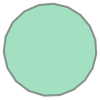

In [13]:
bogota_polygons['Rafael Uribe Uribe']

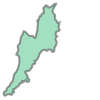

In [14]:
bogota_polygons['Sumapaz']

#### Retriving outlier locations from diferent [map provider](https://global.mapit.mysociety.org/)

In [15]:
rafael_uribe_url = 'https://global.mapit.mysociety.org/area/1047873.geojson'
sumapaz_url = 'https://global.mapit.mysociety.org/area/1050480.geojson'

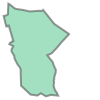

In [16]:
rafael_uribe_json = requests.get(url=rafael_uribe_url).json()
rafael_uribe_polygon = shape(rafael_uribe_json)
rafael_uribe_polygon

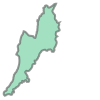

In [17]:
sumapaz_json = requests.get(url=sumapaz_url).json()
sumapaz_polygon = shape(sumapaz_json)
sumapaz_polygon

#### From inspection
- It can be seen that 'Rafael Uribe Uribe' is better describe by the second provider. Sumapaz shape is almost the same for both osm and mapit providers.

#### Saving geojson as csv
- Format: 'location, latitude, longitude'

In [18]:
bogota_polygons['Rafael Uribe Uribe'] = rafael_uribe_polygon

In [19]:
with open("location_coordinates.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["location", "latitud", "longitud"])
    for location, polygon in bogota_polygons.items():
        x, y = polygon.exterior.coords.xy
        latitude = y.tolist()
        longitude = x.tolist()
        location = [location]*len(latitude)
        coordinates = list(zip(location, latitude, longitude))
        writer.writerows(coordinates)